# 概要
- 在庫状況に応じた受注判断AIの構築
  1. 静的な方程式の解$\pi$を求める
    - $\pi$: 在庫1つを保有している場合に期待される収益
  2. 1の解を使って動的な方程式の解$V(x)$を近似する
    - $V_t(x)=V_{t,i}(x_i)+\sum_{k \neq i} x_k  \pi_k$
    - $V(x)$: 在庫状態$x$の場合に見込まれる収益期待値（常に最適なオペレーションを実現した場合を想定）
  3. 動的な方程式の解に基づく判断基準でモンテカルロシミュレーションを実施する
    - $r_0 j+V_{t+1}(x - a) > V_{t+1}(x-a)$なら注文$r_o j$を受注する

# 参考文献
- [Dynamic Pricing for Network Revenue Management:
A New Approach and Application in the Hotel
Industry](https://pdfs.semanticscholar.org/f3f3/3cf3bfb639e5ec35392c3b435f6e746f3c19.pdf)

# parameter setting

In [5]:
!pip install -U pulp
!pip install japanize-matplotlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pulp
import japanize_matplotlib
import seaborn as sns

Requirement already up-to-date: pulp in /usr/local/lib/python3.7/dist-packages (2.4)


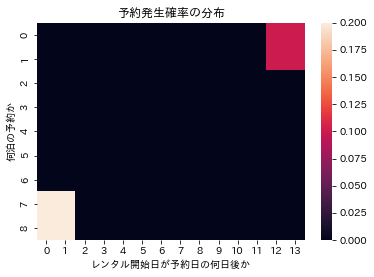

In [6]:
# parameter setting
H=13 #予約までの最大日数
T=60 #シミュレーションの日数
X=np.zeros(T) #X[i]はレンタル時刻iにおける在庫の予約数
points=5 #1日の中で予約を受け付けるタイミング
Tp=T*points #離散時間の個数
C=2 #最大の在庫数
J=8 #最大の連泊数
lam=0.4 #時刻tにおける顧客の到着率
r0=100 #1泊のレンタル料金
#p=np.array( [[0.15 if (j>J-3)&(h<2) else 0.15 if (j<2)&(h>H-3) else 0. for h in range(H+1)] for j in range(J+1)] ) #顧客がh日後のj連泊を選択する確率
p=np.array( [[0.2 if (j>J-2)&(h<2) else 0.1 if (j<2)&(h>H-2) else 0. for h in range(H+1)] for j in range(J+1)] ) #顧客がh日後のj連泊を選択する確率
def pr(r):
  return p if r==r0 else p*0.

sns.heatmap(p)
plt.title('予約発生確率の分布')
plt.xlabel('レンタル開始日が予約日の何日後か')
plt.ylabel('何泊の予約か')
plt.show()

# 静的な方程式の最適解
- 原問題ではなく双対問題の解を用いるため、原問題の係数行列を計算した上で、双対問題を解く

## 原問題

In [ ]:
#問題定義
problem = pulp.LpProblem('revenue management', pulp.LpMaximize)

#変数定義
HH = T #予約を受け付けた日
I = T #予約の開始日
K = T+J #予約の終了日
JJ = 2 #価格の種類
C = C
L = I*(1+HH*K)
r = np.array([r0, r0*100000])
d = np.array([[[[ (j==0)*p[k-i][i-h]*points*lam if (h<=i<=k)&(k-i<=J)&(i-h<=H) else 0 for j in range(JJ)] for k in range(K)] for i in range(I)] for h in range(HH)])
w = np.array([[[[pulp.LpVariable('w_%d,%d,%d,%d'%(h,i,k,j), cat=pulp.LpContinuous) for j in range(JJ)]
                for k in range(K)] for i in range(I)] for h in range(HH)])

##AA = np.zeros((HH,I,K,JJ, L))
##BB = np.zeros((L))
##CC = np.zeros((HH,I,K,JJ))

AA_ = []
BB_ = []
CC_ = []

print('start setting object')
#目的関数の定義
subprobrem = 0
for h in range(HH):
  for i in range(I):
    for k in range(i, K, 1):
      for j in range(JJ):
        subprobrem += max((k-i+1),0)*r[j]*w[h][i][k][j]*d[h][i][k][j]
        ##CC[h][i][k][j] += max((k-i+1),0)*r[j]*d[h][i][k][j]
        if(max((k-i+1),0)*r[j]*d[h][i][k][j]!=0): 
          CC_.append({'h': h, 'i': i, 'k': k, 'j': j, 'l': -1, 'val': max((k-i+1),0)*r[j]*np.log(max((k-i+1),0)*10.+1.)*d[h][i][k][j]})
#problem += pulp.lpDot(CC, w)
problem += subprobrem
print('finish setting object')


print('start setting constraint')
#制約条件の定義
l=0
for i in range(I):
  print('i=%d'%i)
  subprobrem = 0
  for h in range(HH):
    for i2 in range(i-K+1, i, 1):
      for k in range(i-i2+1, K):
        for j in range(JJ):
          subprobrem += w[h][i][k][j]*d[h][i][k][j]
          ##AA[h][i][k][j][l] += d[h][i][k][j]
          if(d[h][i][k][j]!=0):
            AA_.append({'h': h, 'i': i, 'k': k, 'j': j, 'l': l, 'val': d[h][i][k][j]})
  ##BB[l] += C
  BB_.append({'l': l, 'val': C})
  problem += subprobrem <= C
  l+=1
print('finish setting constraint#1')

for h in range(HH):
  for i in range(I):
    for k in range(K):
      subprobrem = 0
      for j in range(JJ):
        subprobrem += w[h][i][k][j]
        ##AA[h][i][k][j][l] += 1
        AA_.append({'h': h, 'i': i, 'k': k, 'j': j, 'l': l, 'val': 1})
      ##BB[l] += 1
      BB_.append({'l': l, 'val': 1})
      problem += subprobrem <= 1
      l+=1
print('finish setting constraint#2')

for h in range(HH):
  for i in range(I):
    for k in range(K):
      for j in range(JJ):
        problem += w[h][i][k][j] >= 0
print('finish setting constraint#3')

print('start solving problem')
#最適化
status = problem.solve()
print('finish solving problem')

print("Status", pulp.LpStatus[status])
print("Result")

res = 0
for h in range(HH):
  for i in range(I):
    for k in range(K):
      for j in range(JJ):
        res += max((k-i+1),0)*r[j]*w[h][i][k][j].value()*d[h][i][k][j]

print(res)

AA_.extend(CC_)
AA2_ = pd.DataFrame(AA_).groupby(['h', 'i', 'k', 'j', 'l']).agg(val=('val', 'sum')).pipe(lambda df: df[df['val']!=0]).reset_index()

/usr/local/lib/python3.6/dist-packages/pulp/pulp.py:1199: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


start setting object
finish setting object
start setting constraint
i=0
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
i=11
i=12
i=13
i=14
i=15
i=16
i=17
i=18
i=19
i=20
i=21
i=22
i=23
i=24
i=25
i=26
i=27
i=28
i=29
i=30
i=31
i=32
i=33
i=34
i=35
i=36
i=37
i=38
i=39
i=40
i=41
i=42
i=43
i=44
i=45
i=46
i=47
i=48
i=49
i=50
i=51
i=52
i=53
i=54
i=55
i=56
i=57
i=58
i=59
finish setting constraint#1
finish setting constraint#2
finish setting constraint#3
start solving problem
finish solving problem
Status Optimal
Result
4197.0638984


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

files_path = './drive/My Drive/Analytics/Dynamic Pricing/受注判定AI開発/'
with open(files_path+'AA2_.pickle', 'wb') as f:
  pickle.dump(AA2_, f)

with open(files_path+'AA_.pickle', 'wb') as f:
  pickle.dump(AA_, f)

with open(files_path+'BB_.pickle', 'wb') as f:
  pickle.dump(BB_, f)

with open(files_path+'CC_.pickle', 'wb') as f:
  pickle.dump(CC_, f)

In [ ]:
import pickle

files_path = './drive/My Drive/Analytics/Dynamic Pricing/受注判定AI開発/'
with open(files_path+'AA2_.pickle', 'rb') as f:
  AA2_ = pickle.load(f)

with open(files_path+'AA_.pickle', 'rb') as f:
  AA_ = pickle.load(f)

with open(files_path+'BB_.pickle', 'rb') as f:
  BB_ = pickle.load(f)

with open(files_path+'CC_.pickle', 'rb') as f:
  CC_ = pickle.load(f)

##双対問題

In [ ]:
#問題定義
problem2 = pulp.LpProblem('revenue management2', pulp.LpMinimize)
pi = np.array([pulp.LpVariable('pi_%d'%l, cat=pulp.LpContinuous) for l in range(L)])

#目的関数の定義
print('start setting object')
subproblem = 0
for bb in BB_:
  subproblem += 1.0 * bb['val'] * pi[bb['l']]
problem2 += subproblem
print('finish setting object')


print('start setting constraint')
#制約条件の定義
subproblem = 0
for _, _df in AA2_.groupby(['h', 'i', 'k', 'j']):
  subproblem = 0
  for l, val in zip(_df[_df['l']>=0]['l'], _df[_df['l']>=0]['val']):
    subproblem += val * pi[l]
  problem2 += subproblem >= _df[_df['l']==-1]['val']
print('finish setting constraint#1')

for l in range(L):
  problem2 += pi[l] >= 0
print('finish setting constraint#2')



print('start solving problem')
#最適化
status2 = problem2.solve()
print("Status", pulp.LpStatus[status2])

print("Result")

res = 0
for bb in BB_:
  res += bb['val'] * pi[bb['l']].value()
res

/usr/local/lib/python3.6/dist-packages/pulp/pulp.py:1199: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


start setting object
finish setting object
start setting constraint
finish setting constraint#1
finish setting constraint#2
start solving problem
Status Optimal
Result


18885.212605999994

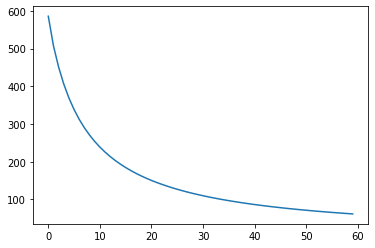

In [ ]:
pi2 = np.vectorize(lambda x: x.value())(pi)
plt.plot(pi2[0:T])
plt.show()

In [ ]:
with open(files_path+'pi2.pickle', 'wb') as f:
  pickle.dump(pi2, f)

In [ ]:
with open(files_path+'pi2.pickle', 'rb') as f:
  pi22 = pickle.load(f)

# 動的な方程式の最適解

In [ ]:
# calculation
V=np.zeros((Tp+1, len(X), C+1)) #V[t][i][xi]は時刻tにおいて、レンタル時刻iの在庫がx[i]個存在する場合の期待収益
V2=np.zeros((Tp+1, len(X), C+1)) #V[t][i][xi]が最適化されたver
dV=np.zeros((Tp+1, len(X), C+1, J+1, H+1)) #dV[t][i][xi][j][h]は時刻tにおいて、レンタル時刻iの在庫がx[i]個存在する場合に、
                                                                #h日後にj連泊の予約が発生した際の期待収益
dV2=np.zeros((Tp+1, len(X), C+1, J+1, H+1)) #dV2が最適化されたver


for tp in range(Tp-1, -1, -1):
  t=int(tp/points)
  for i in range(t, len(X), 1):
    for x in range(1, C+1, 1):
      V[tp][i][x] += V[tp+1][i][x]
      V2[tp][i][x] += V2[tp+1][i][x]

      for j in range(0, J+1, 1):
        for h in range(0, H+1, 1):
          #時刻tにおいて、レンタル時刻iに在庫数xを抱えた状態で、h日後開始のj日連泊の契約が発生
          j_ = min( j, max(T-(t+h),0) )
          dV[tp][i][x][j_][h] = lam*p[j][h]*(j_*r0 * np.log(j_*10. +1.) - (V[tp+1][i][x] - V[tp+1][i][x-1 if t+h<= i <t+h+j_ else x]))
          dV2[tp][i][x][j_][h] = lam*p[j][h]*(j_*r0 * np.log(j_*10. +1.) - (V2[tp+1][i][x] - V2[tp+1][i][x-1 if t+h<= i <t+h+j_ else x]))

          for k in range(t+h, t+h+j_,1):
            dV[tp][i][x][j_][h] += lam*p[j][h]*(-pi2[k])
            dV2[tp][i][x][j_][h] += lam*p[j][h]*(-pi2[k])

          V[tp][i][x] += dV[tp][i][x][j_][h]
          V2[tp][i][x] += max(dV2[tp][i][x][j_][h], 0)

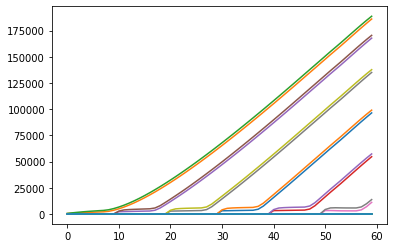

In [ ]:
for i in range(len(V2)):
  if (i%50)==0:
    plt.plot(V2[i])

# 動的最適化アプローチに基づく受注判断シミュレーション

In [ ]:
# 動的最適化アプローチに基づく判断基準の定義
def judge(xx, h, i, j, t, tp):
  res = r0 * j * np.log(j * 10. + 1.)
  for x, k in zip(xx, range(len(xx))):
    #res -= (V2[tp+1][k][x] - V2[tp+1][k][x-1 if t+h<= k <t+h+j else x])
    if k==i:
      res -= (V2[tp+1][k][x] - V2[tp+1][k][x-1 if t+h<= k <t+h+j else x])
    else:
      res -= pi2[k] * (t+h<= k <t+h+j )
  #print(res)
  return res

In [ ]:
#simulation
class Order:
  def __init__(self, x=[], T=T, H=H, C=C, J=J, lam=lam, p=p):
    self.tp=0
    self.points=points
    self.H=H #予約までの最大日数
    self.T=T #シミュレーションの期間
    self.Tp=self.T*self.points
    self.C=C #最大の在庫数
    self.J=J #最大の連泊数
    if len(x)>0:
      self.x1= copy.copy(x) #X[i]はレンタル時刻iにおける在庫の予約数
      self.sim_mode = 1 #この場合、x1についてのみシミュレーション実行
    else:
      self.x1= np.zeros(self.T, dtype=int) + C #X[i]はレンタル時刻iにおける在庫の予約数
      self.x2= np.zeros(self.T, dtype=int) + C #X[i]はレンタル時刻iにおける在庫の予約数
      self.x3= np.zeros(self.T, dtype=int) + C #X[i]はレンタル時刻iにおける在庫の予約数
      self.sim_mode = 2 #この場合、x1, x2についてシミュレーション実行
    self.revenue1=[]
    self.revenue2=[]
    self.revenue3=[]
    self.lam=lam #時刻tにおける顧客の到着率
    self.r0=r0 #1泊のレンタル料金
    self.p=p #顧客がh日後のj連泊を選択する確率
    self.ph=self.p[1][1:]/self.p[1][1:].sum()

  def receive_oder(self):
    #self.num_customers = np.random.binomial(1, self.lam)
    self.num_customers = np.random.binomial(1, self.lam * p.sum())
    hj=np.random.choice(
        a=np.array([[10000*j+h for h in range(H+1)] for j in range(J+1)]).flatten(), 
        p=p.flatten()/p.sum())
    self.term_resavation = hj % 10000
    self.after = hj // 10000
    #self.term_resavation = 1 if np.random.binomial(1, 0.5) else J
    #self.after = np.random.choice([h for h in range(1, self.H+1)], p=self.ph)

  def reserve_room(self):
    self.t=int(self.tp/self.points)
    #print(self.t)
    start = min(self.t+self.after, self.T-1)
    end = min(start+self.term_resavation, self.T-1)
    term = end - start
    if self.num_customers*(end>start) == 0: return
    if (self.x1[start:end] < 1).sum() == 0:
      #とりあえず予約を受け付ける場合
      self.x1[start:end] = self.x1[start:end] - 1
      self.revenue1.append(self.r0 * term * np.log(term*10+1))

    # 期待収益計算に基づき予約を受け付ける場合
    if self.sim_mode==2:
      if (self.x2[start:end] < 1).sum() == 0:
        jd = judge(self.x2, self.after, start, term, self.t, self.tp)
        if jd >= 0:
          self.x2[start:end] = self.x2[start:end] -1
          self.revenue2.append(self.r0 * term * np.log(term*10+1))

      #2日以上の予約のみ受け付ける場合
      if ((self.x3[start:end] < 1).sum() == 0) & (term>1):
        self.x3[start:end] = self.x3[start:end] - 1
        self.revenue3.append(self.r0 * term * np.log(term*10+1))

  def pass_one_day(self):
    self.receive_oder()
    self.reserve_room()
    self.tp += 1
  
  def simulate(self):
    for i in range(self.Tp):
      self.pass_one_day()

In [ ]:
# モンテカルロシミュレーションの実行
rate1 = [] # 機械学習アプローチ vs 短期オペ
rate2 = [] # 長期オペ vs 短期オペ
rate3 = [] # 機械学習アプローチ vs 長期オペ
for i in range(1000):
  order = Order(x=[], T=T2)
  order.simulate()
  rate1.append(sum(order.revenue2)/(sum(order.revenue1)))
  rate2.append(sum(order.revenue3)/(sum(order.revenue1)))
  rate3.append(sum(order.revenue2)/(sum(order.revenue3)))

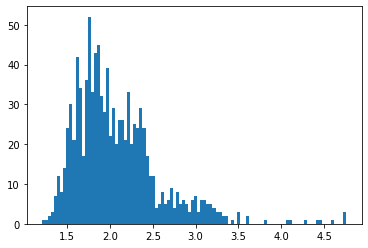

2.0764830915793735

In [ ]:
# 機械学習アプローチ vs 短期オペ
plt.hist(rate1, bins=100)
plt.show()
np.mean(rate1)

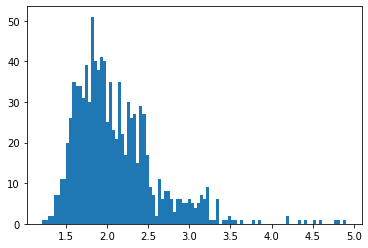

2.102919326673038

In [ ]:
# 長期オペ vs 短期オペ
plt.hist(rate2, bins=100)
plt.show()
np.mean(rate2)

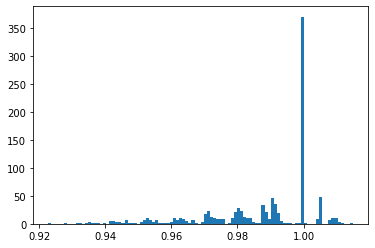

0.987548374604094

In [ ]:
# 機械学習アプローチ vs 長期オペ
plt.hist(rate3, bins=100)
plt.show()
np.mean(rate3)